# Notebook 60: Interpolating from MESA grids to a large population

In [2]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match 
# the first two digits in the notebook's title
nb_id = 60

## Imports

In [29]:

from pathlib import Path
from math import isnan, nan

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, TwoSlopeNorm, to_rgba
from matplotlib.lines import Line2D
from functools import partial

import astropy.units as u
import astropy.constants as ct
from astropy.cosmology import WMAP9 as cosmo
from scipy.signal import find_peaks
from scipy.interpolate import interp1d, RegularGridInterpolator
from scipy.stats import linregress

from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

import mesa_reader as mr
import mesaPlot as mp
import tulips as tp

import sys
sys.path.append('..')
from src.binary import eggleton_rl1_radius, a_from_p, p_from_a, marchant_l2_radius
from src.util import DATA_ROOT, MESA_DATA_ROOT, build_bump35_cmap, build_logbump35_cmap

plt.style.use('./plotstyle.mplstyle')
pd.set_option('display.max_columns', None)

In [30]:
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [31]:
plt.style.use('./plotstyle.mplstyle')

## Definitions

### Constants

In [32]:
Z_SUN = 0.017
t_h = cosmo.age(0).to(u.yr).value

### Utilities

In [7]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [8]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [9]:
def get_model_folder(model_id, project_folder, verbose=True):
    """Finds model folder given its id."""
    matches = list(project_folder.glob(f'{model_id}*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {project_folder}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {project_folder}')
        return           

In [10]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        try:
            m, p, w = model_folder.name.replace('d', 'e').split('_')
            w = float(w.lstrip('w'))
            p = f'{float(p.lstrip("p")):.2f}'      
        except ValueError:
            m, w = model_folder.name.replace('d', 'e').split('_')   
            w = float(w.lstrip('w'))
            p = (2*np.pi/w) / (60*60*24)
        m = f'{float(m.lstrip("m")):.1f}'
        
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [11]:
def mesareader_operator(expression, object_to_call='h'):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication, division and exp10."""
    operations = ['+', '-', '*', '/', '^', 'E', '(', ')', ',']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'{object_to_call}.__getattr__("{char}'
        else:
            if char == '^':
                char = '10**'
            elif char == 'E':
                char = 'gamma_e('
            mr_expression += f'{char}{object_to_call}.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        if char == '^':
            char = '10**'
        elif char == 'E':
                char = 'gamma_e('
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


In [12]:
def draw_mass_sample(
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_mfinal=20,
    max_mfinal=50,
    mfinal_bin_width=0.2
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([l2_mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))

    sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores]).T
    zams_l2of_sample = set_mcores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 3]
    mass_draw = mass_draw[~np.isnan(mass_draw)]

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

In [13]:
def is_of(r, m, p, q=1, kind='RL'):
    a = a_from_p(p, m, q)
    if kind == 'merger':
        of_a = a.to(u.Rsun).value
    elif kind == 'RL':
        of_a = eggleton_rl1_radius(a, q).to(u.Rsun).value
    elif kind == 'L2':
        of_a = marchant_l2_radius(a, q).to(u.Rsun).value
    elif kind == 'none':
        of_a = np.inf
    else:
        raise ValueError(f'kind {kind} not recognized')
    if of_a <= r:
        isof = True
    else:
        isof = False

    return isof

## Generating an interpolated population

Let us load and organize our grids first.

In [14]:
def load_models(project_folder):
    model_folders = list(project_folder.glob('*_md*_m*_zsundiv*_*y0_*dy'))
    _model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
    model_dicts = dict()
    for dicts in _model_dicts:
        for m in dicts.keys():
            if m not in model_dicts.keys():
                model_dicts[m] = dicts[m]
    return model_dicts

In [15]:
project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4'
model_dicts_00005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/08_ZdivZsun_5d-3'
model_dicts_0005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/07_ZdivZsun_2d-2'
model_dicts_002zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/06_ZdivZsun_5d-2'
model_dicts_005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1'
model_dicts_01zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1'
model_dicts_02zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1'
model_dicts_04zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/03_ZdivZsun_6d-1'
model_dicts_06zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1'
model_dicts_08zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0'
model_dicts_10zsun = load_models(project_folder)


all_model_dicts = {
    '0.0005': model_dicts_00005zsun,
    '0.005': model_dicts_0005zsun,
    '0.02': model_dicts_002zsun,
    '0.05': model_dicts_005zsun,
    '0.1': model_dicts_01zsun,
    '0.2': model_dicts_02zsun,
    '0.4': model_dicts_04zsun,
    '0.6': model_dicts_06zsun,
    '0.8': model_dicts_08zsun,
    '1.0': model_dicts_10zsun
}

final_core_prop_array_dict = {
    '0.0005': np.load(DATA_ROOT/'09_enhanced_w_core_props.npy'),
    '0.005': np.load(DATA_ROOT/'08_enhanced_w_core_props.npy'),
    '0.02': np.load(DATA_ROOT/'07_enhanced_w_core_props.npy'),
    '0.05': np.load(DATA_ROOT/'06_enhanced_w_core_props.npy'),
    '0.1': np.load(DATA_ROOT/'00_enhanced_w_core_props_v2.npy'),
    '0.2': np.load(DATA_ROOT/'01_enhanced_w_core_props_v2.npy'),
    '0.4': np.load(DATA_ROOT/'02_enhanced_w_core_props.npy'),
    '0.6': np.load(DATA_ROOT/'03_enhanced_w_core_props.npy'),
    '0.8': np.load(DATA_ROOT/'04_enhanced_w_core_props.npy'),
    '1.0': np.load(DATA_ROOT/'05_enhanced_w_core_props.npy')
}

In [16]:
model_dict = model_dicts_01zsun
m_axis = np.array(list(model_dict.keys()))
m_axis = m_axis[np.float64(m_axis).argsort()]
p_axis = np.array(list(model_dict[m_axis[0]].keys()))
p_axis = p_axis[np.float64(p_axis).argsort()]

In [17]:
core_props_df = pd.read_hdf(DATA_ROOT/'core_props_df.h5')

In [18]:
core_props_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1600 entries, 0 to 1599
Data columns (total 64 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   z_key               1600 non-null   object 
 1   m_zams              1600 non-null   float64
 2   m_wr0               420 non-null    float64
 3   m_wr1               420 non-null    float64
 4   m_tams              420 non-null    float64
 5   m_tahems            420 non-null    float64
 6   m_f                 420 non-null    float64
 7   m_c_zams            420 non-null    float64
 8   m_c_wr0             420 non-null    float64
 9   m_c_wr1             420 non-null    float64
 10  m_c_tams            420 non-null    float64
 11  m_c_tahems          420 non-null    float64
 12  m_c_f               420 non-null    float64
 13  inertia_zams        420 non-null    float64
 14  inertia_wr0         420 non-null    float64
 15  inertia_wr1         420 non-null    float64
 16  inertia_tam

In [19]:
def set_x(row, stage='f'):
    j = 10.**row[f'log_j_{stage}'] * u.g * u.cm**2 / u.s
    m = row[f'm_{stage}'] * u.Msun
    x = ct.c * j / ct.G / m**2
    x = x.to(u.dimensionless_unscaled).value
    return x

stages = ['zams', 'wr0', 'wr1', 'tams', 'tahems', 'f']
for stage in stages:
    core_props_df[f'x_{stage}'] = core_props_df.apply(lambda row: set_x(row, stage=stage), axis=1)

In [20]:
def set_min_x(row, stage='f'):
    i = row[f'inertia_{stage}'] * u.g * u.cm**2
    p = row[f'p_orb_{stage}'] * u.d
    m = row[f'm_{stage}'] * u.Msun
    w = 2*np.pi / p.to(u.s)
    min_j = i * w
    min_x = ct.c * min_j / ct.G / m**2
    min_x = min_x.to(u.dimensionless_unscaled).value
    return min_x

for stage in stages:
    core_props_df[f'min_x_{stage}'] = core_props_df.apply(lambda row: set_min_x(row, stage=stage), axis=1)

In [21]:
z_axis = core_props_df.z_key.unique()
z_axis = z_axis[np.float64(z_axis).argsort()]

In [22]:
core_props_df.is_che = core_props_df.is_che.astype(bool)

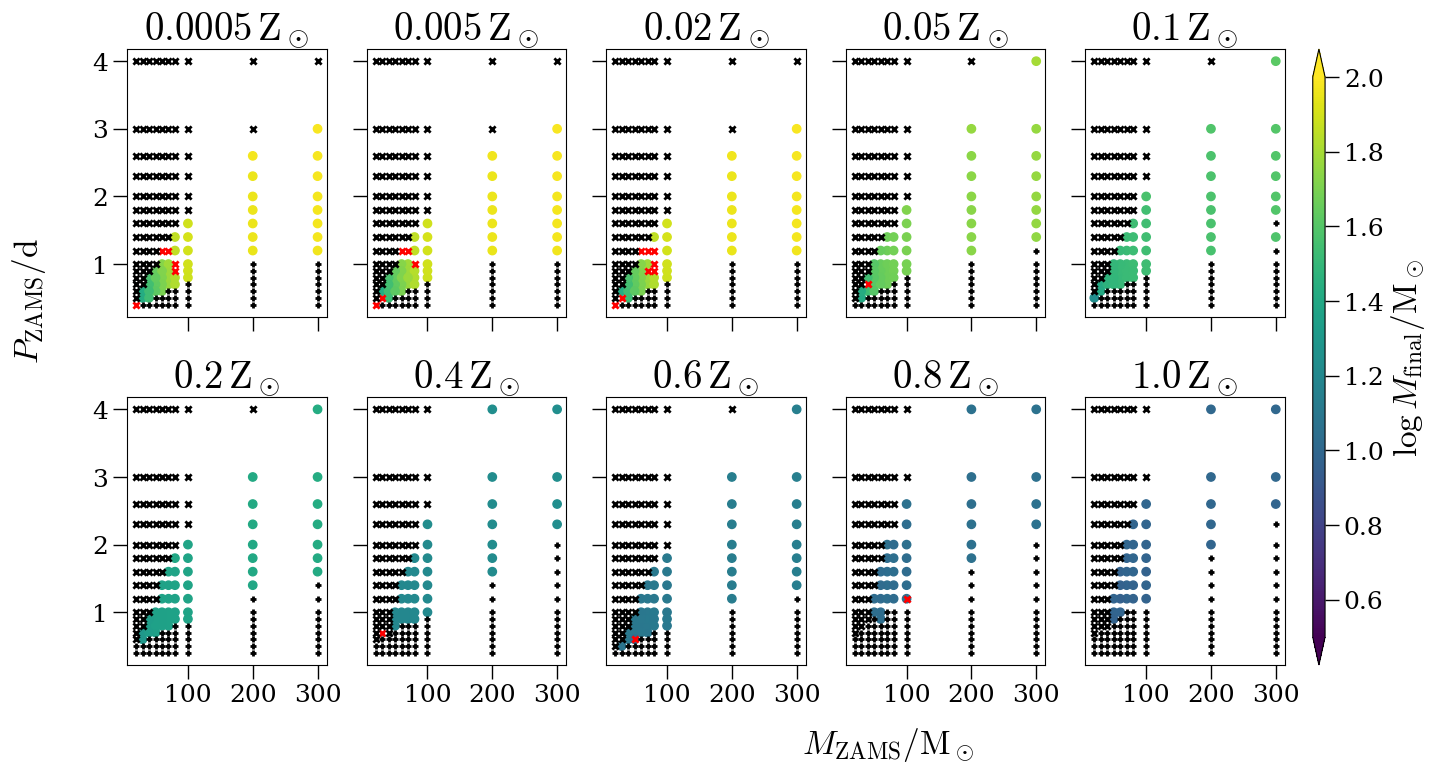

In [23]:
fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3)
mf_min = 0.5
mf_max = 2
cmap = cm.viridis

for ax, z_key in zip(axes.flatten(), core_props_df.z_key.unique()):
    ax.scatter(
        core_props_df[core_props_df.z_key==z_key].m_zams,
        core_props_df[core_props_df.z_key==z_key].p_spin_zams,
        c=cmap(
            (np.log10(core_props_df[core_props_df.z_key==z_key].m_f) - mf_min) / (mf_max-mf_min))
    )
    ax.set_title(f'${z_key}\\,\\mathrm{{Z}}_\\odot$')
    
    crash_df = core_props_df[core_props_df.is_crash]
    ax.scatter(
        crash_df[crash_df.z_key==z_key].m_zams,
        crash_df[crash_df.z_key==z_key].p_spin_zams,
        marker='x', c='red', s=20, label='crash'
    )
    
    nonche_df = core_props_df[~core_props_df.is_che]
    ax.scatter(
        nonche_df[nonche_df.z_key==z_key].m_zams,
        nonche_df[nonche_df.z_key==z_key].p_spin_zams,
        marker='x', c='black', s=20, label='non-che'
    )
    
    crit_df = core_props_df[core_props_df.is_crit_at_zams]
    ax.scatter(
        crit_df[crit_df.z_key==z_key].m_zams,
        crit_df[crit_df.z_key==z_key].p_spin_zams,
        marker='+', c='black', s=20, label='crit'
    )
    
fig.text(0.06, 0.5, '$P_\\mathrm{ZAMS}/\\mathrm{d}$', fontsize=24, rotation=90)
fig.text(0.5, 0, '$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$', fontsize=24)

sm = cm.ScalarMappable(norm=Normalize(vmin=mf_min, vmax=mf_max), cmap=cmap)
cb = fig.colorbar(sm, ax=axes, orientation='vertical', extend='both', pad=0.02, aspect=50)
cb.set_label('$\\log M_\\mathrm{final}/\\mathrm{M}_\\odot$', fontsize=24)

savefig(fig, 'che_windows_over_z_viridis')

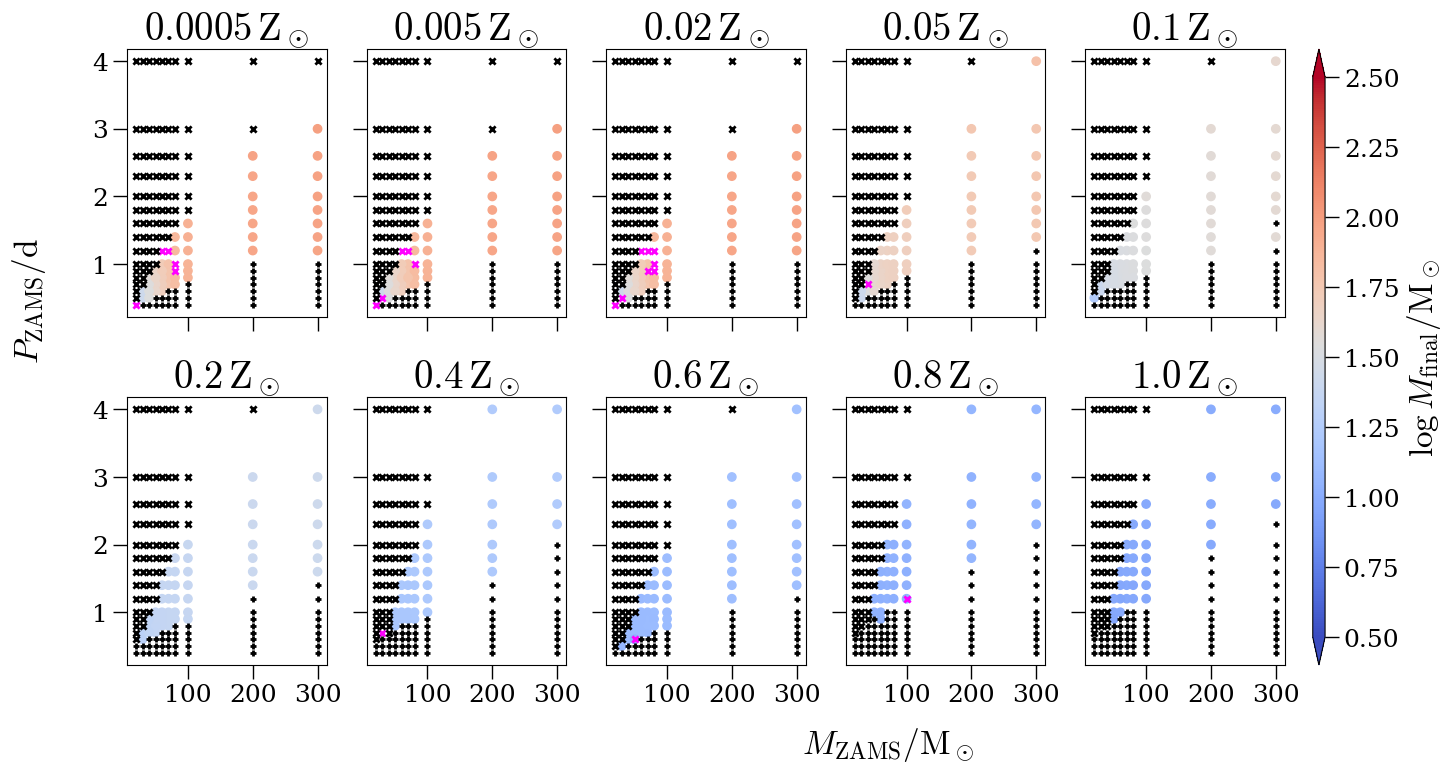

In [35]:
fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3)
mf_min = 0.5
mf_max = 2.5
cmap = build_logbump35_cmap(vmin=mf_min, vmax=mf_max, base_cmap=cm.coolwarm)

for ax, z_key in zip(axes.flatten(), core_props_df.z_key.unique()):  
    #ax.set_facecolor('lightgrey')
    ax.scatter(
        core_props_df[core_props_df.z_key==z_key].m_zams,
        core_props_df[core_props_df.z_key==z_key].p_spin_zams,
        marker='o',
        c=cmap(
            (np.log10(core_props_df[core_props_df.z_key==z_key].m_f) - mf_min) / (mf_max-mf_min)),
        ),
    
    ax.set_title(f'${z_key}\\,\\mathrm{{Z}}_\\odot$')
    
    crash_df = core_props_df[core_props_df.is_crash]
    ax.scatter(
        crash_df[crash_df.z_key==z_key].m_zams,
        crash_df[crash_df.z_key==z_key].p_spin_zams,
        marker='x', c='magenta', s=20, label='crash'
    )
    
    nonche_df = core_props_df[~core_props_df.is_che]
    ax.scatter(
        nonche_df[nonche_df.z_key==z_key].m_zams,
        nonche_df[nonche_df.z_key==z_key].p_spin_zams,
        marker='x', c='black', s=20, label='non-che'
    )
    
    crit_df = core_props_df[core_props_df.is_crit_at_zams]
    ax.scatter(
        crit_df[crit_df.z_key==z_key].m_zams,
        crit_df[crit_df.z_key==z_key].p_spin_zams,
        marker='+', c='black', s=20, label='crit'
    )
    
fig.text(0.06, 0.5, '$P_\\mathrm{ZAMS}/\\mathrm{d}$', fontsize=24, rotation=90)
fig.text(0.5, 0, '$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$', fontsize=24)

sm = cm.ScalarMappable(norm=Normalize(vmin=mf_min, vmax=mf_max), cmap=cmap)
cb = fig.colorbar(sm, ax=axes, orientation='vertical', extend='both', pad=0.02, aspect=50)
cb.set_label('$\\log M_\\mathrm{final}/\\mathrm{M}_\\odot$', fontsize=24)

savefig(fig, 'che_windows_over_z_seismic')

In [36]:
class PMZLinearInterpolator:
    
    def __init__(self, data, var='m_f', bounds_error=False, fill_value=np.nan, verbose=False):
        self.data = data
        self.var = var
        self.bounds_error = bounds_error
        self.fill_value = fill_value
        self.verbose = verbose 
        self.p_interpolators = self._get_p_interpolators()       
        
    def _get_p_interpolators(self):
        """Sets p interpolators for all m_zams and z_key combinations."""
        p_interpolators = {}
        for z_key in self.data.z_key.unique():
            p_interpolators[z_key] = {}
            for m_key in self.data.m_zams.unique():
                p_interpolator = self._get_p_interpolator(m_key, z_key)
                p_interpolators[z_key][m_key] = p_interpolator
        return p_interpolators

    def _get_p_interpolator(self, m_key, z_key):
        ip_data = self.data.copy()
        ip_data = ip_data[ip_data.is_che & ~ip_data.is_merger_at_zams]
        
        m_zams = round(float(m_key), 1)
        ip_x = ip_data[
            (ip_data.z_key == z_key)
            & (ip_data.m_zams == m_zams)
        ].p_spin_zams.values
        ip_y = ip_data[
            (ip_data.z_key == z_key)
            & (ip_data.m_zams == m_zams)
        ][self.var].values
        
        if len(ip_x) == 0 or len(ip_y) == 0:
            if self.bounds_error:
                raise ValueError(f'No data for m_zams={m_zams}, z={z_key}')
            else:
                if self.verbose:
                    print(f'Warning: No data for m_zams={m_zams}, z_key={z_key}. Returning empty interpolator.')
                return interp1d([np.nan], [np.nan], bounds_error=False, fill_value=self.fill_value)
        
        ip_y = ip_y[ip_x.argsort()]
        ip_x = np.sort(ip_x)
        series = pd.Series(ip_y, index=ip_x)
        ip_y = series.interpolate(method='slinear', limit_area=None, limit_direction='both').values

        p_interpolator = interp1d(
            ip_x,
            ip_y,
            bounds_error=self.bounds_error,
            fill_value=self.fill_value
        )
        return p_interpolator

    def _get_m_interpolator(self, p_spin_zams, z_key):
        ip_x = []
        ip_y = []
        for m_key, p_interpolator in self.p_interpolators[z_key].items():
            ip_x.append(float(m_key))
            ip_y.append(p_interpolator(p_spin_zams))
        ip_x = np.array(ip_x)
        ip_y = np.array(ip_y)

        ip_y = ip_y[ip_x.argsort()]
        ip_x = np.sort(ip_x)    
        #series = pd.Series(ip_y, index=ip_x)
        #ip_y = series.interpolate(method='linear', limit_area='inside', limit_direction='both').values
                # Find indices where ip_y is nan and surrounded by non-nans

        m_interpolator = interp1d(
            ip_x, 
            ip_y, 
            bounds_error=self.bounds_error, 
            fill_value=self.fill_value
        )
        return m_interpolator
    
    def _get_z_interpolator(self, m_zams, p_spin_zams):
        ip_x = []
        ip_y = []
        for z_key in self.p_interpolators.keys():
            m_interpolator = self._get_m_interpolator(p_spin_zams, z_key)
            ip_x.append(np.log10(float(z_key)))
            ip_y.append(m_interpolator(m_zams))
        ip_x = np.array(ip_x)
        ip_y = np.array(ip_y)
            
        ip_y = ip_y[ip_x.argsort()]
        ip_x = np.sort(ip_x)
        #series = pd.Series(ip_y, index=ip_x)
        #ip_y = series.interpolate(method='linear', limit_area='inside', limit_direction='both').values
            
        logz_interpolator = interp1d(
            ip_x, 
            ip_y, 
            bounds_error=self.bounds_error, 
            fill_value=self.fill_value
        )
        def z_interpolator(z):
            return logz_interpolator(np.log10(z))
        
        return z_interpolator
    
    def get_var(self, m, p, z):
        interpolator = self._get_z_interpolator(m, p)
        return interpolator(z)
            

In [37]:
interpolator = PMZLinearInterpolator(core_props_df, var='m_f')

In [38]:
get_mf = np.vectorize(interpolator.get_var)

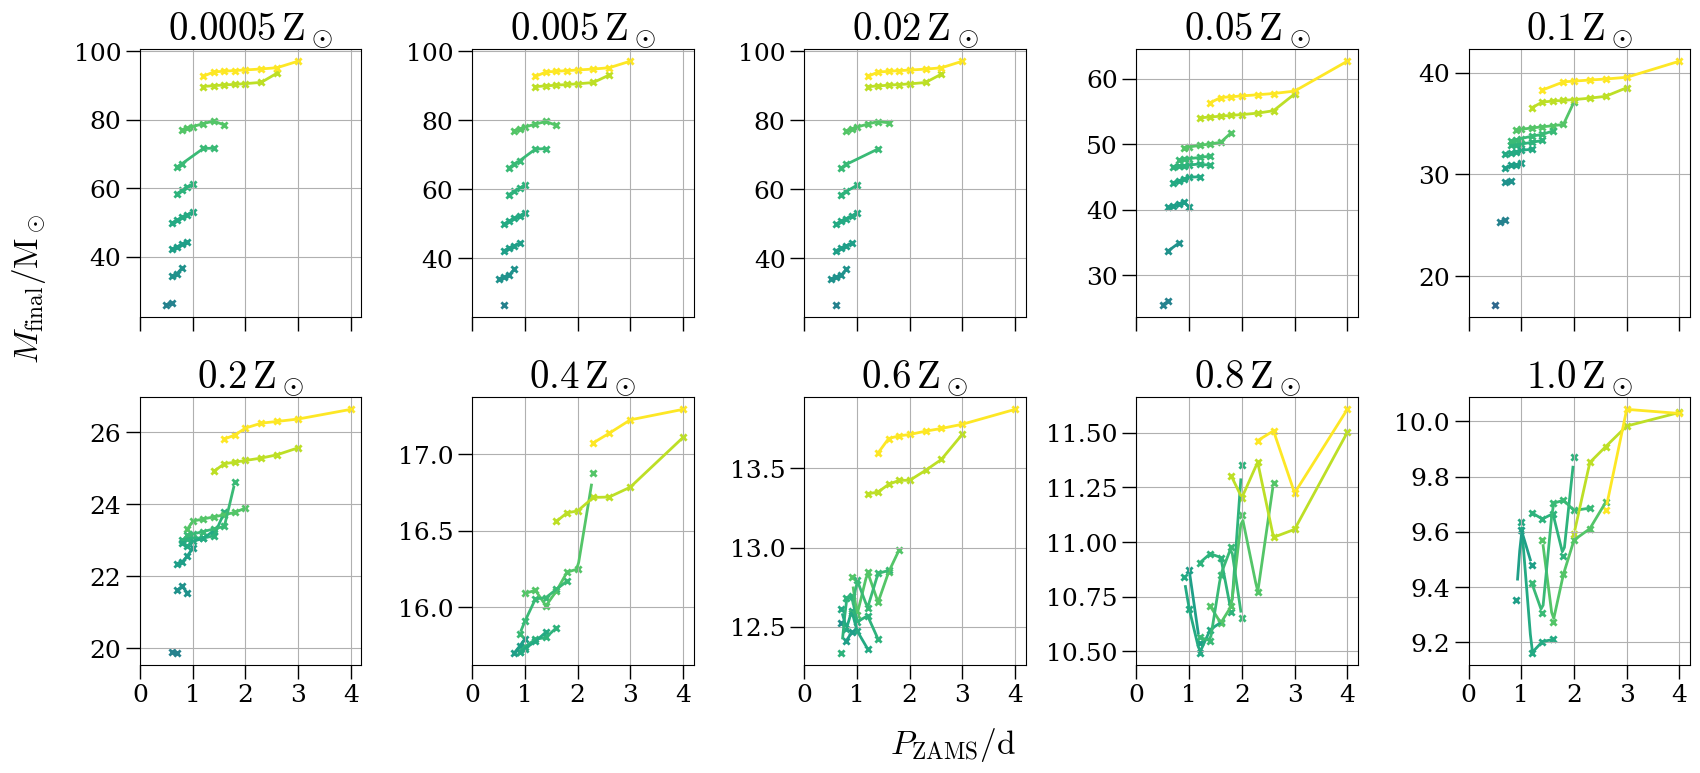

In [39]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=True)
fig.subplots_adjust(hspace=0.3, wspace=0.5)
cmap = cm.viridis

for ax, z_key in zip(axes.flatten(), core_props_df.z_key.unique()):
    subdf = core_props_df[
        (core_props_df.z_key == z_key)
        & ~core_props_df.is_merger_at_zams
        ]
    for m in subdf.m_zams.unique():
        c = cmap((np.log10(m)-np.log10(5))/(np.log10(300)-np.log10(5)))
        subsubdf = subdf[subdf.m_zams == m]
        ax.scatter(subsubdf.p_spin_zams, subsubdf.m_f, color=c, marker='x', s=20)
        x = np.linspace(0, 4, 100)
        ax.plot(x, get_mf(m, x, float(z_key)), c=c)
    ax.set_xlim(0.1, 4.2)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.grid()
    ax.set_title(f'${z_key}\\,\\mathrm{{Z}}_\\odot$')
    
#ax.set_yscale('log')
fig.text(0.06, 0.5, '$M_\\mathrm{final}/\\mathrm{M}_\\odot$', fontsize=24, rotation=90)
fig.text(0.5, 0, '$P_\\mathrm{ZAMS}/\\mathrm{d}$', fontsize=24)

savefig(fig, 'interpolator_consistency_check')

## An analytical fit for the boundaries of the CHE window

Text(0.5, 0, '$P_\\mathrm{ZAMS}/\\mathrm{d}$')

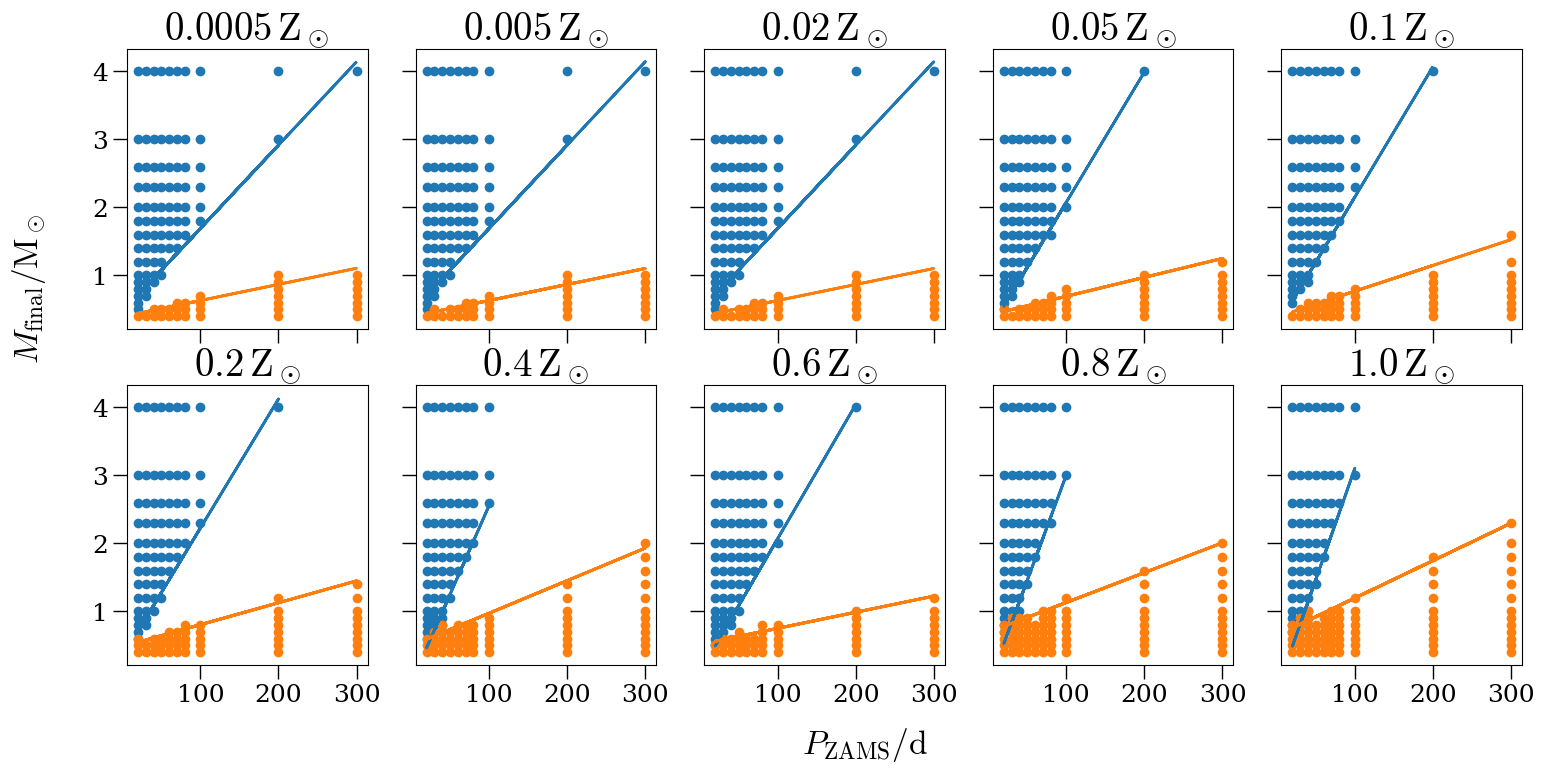

In [40]:
fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)

che_window_upper_boundary_fits = np.zeros((len(core_props_df.z_key.unique()), 3))
for i, z_key in enumerate(core_props_df.z_key.unique()):
    subdf = core_props_df[(core_props_df.z_key==z_key)
                          & (~core_props_df.is_che)]
    x = []
    y = []
    for m in subdf.m_zams.unique():
        x.append(m)
        y.append(subdf[subdf.m_zams==m].p_spin_zams.min())
    slope, norm, *_ = linregress(x, y)
    che_window_upper_boundary_fits[i] = [np.log10(float(z_key)), slope, norm]
    axes.flatten()[i].plot(
        subdf.m_zams,
        slope*subdf.m_zams + norm)
    axes.flatten()[i].scatter(
        subdf.m_zams,
        subdf.p_spin_zams
    )
    
    
che_window_lower_boundary_fits = np.zeros((len(core_props_df.z_key.unique()), 3))
for i, z_key in enumerate(core_props_df.z_key.unique()):
    subdf = core_props_df[(core_props_df.z_key==z_key)
                          & (core_props_df.is_merger_at_zams)]
    x = []
    y = []
    for m in subdf.m_zams.unique():
        x.append(m)
        y.append(subdf[subdf.m_zams==m].p_spin_zams.max())
    slope, norm, *_ = linregress(x, y)
    che_window_lower_boundary_fits[i] = [np.log10(float(z_key)), slope, norm]
    axes.flatten()[i].plot(
        subdf.m_zams,
        slope*subdf.m_zams + norm)
    axes.flatten()[i].scatter(
        subdf.m_zams,
        subdf.p_spin_zams
    )

    axes.flatten()[i].set_title(f'${z_key}\\,\\mathrm{{Z}}_\\odot$')
    
fig.text(0.06, 0.5, '$M_\\mathrm{final}/\\mathrm{M}_\\odot$', fontsize=24, rotation=90)
fig.text(0.5, 0, '$P_\\mathrm{ZAMS}/\\mathrm{d}$', fontsize=24)

In [41]:
che_w_upper_bound_slope_ip = interp1d(
    che_window_upper_boundary_fits[:, 0],
    che_window_upper_boundary_fits[:, 1],
    kind='linear',
    bounds_error=False,
    fill_value='extrapolate'
)
che_w_upper_bound_norm_ip = interp1d(
    che_window_upper_boundary_fits[:, 0],
    che_window_upper_boundary_fits[:, 2],
    kind='linear',
    bounds_error=False,
    fill_value='extrapolate'
)
che_w_lower_bound_slope_ip = interp1d(
    che_window_lower_boundary_fits[:, 0],
    che_window_lower_boundary_fits[:, 1],
    kind='linear',
    bounds_error=False,
    fill_value='extrapolate'
)
che_w_lower_bound_norm_ip = interp1d(
    che_window_lower_boundary_fits[:, 0],
    che_window_lower_boundary_fits[:, 2],
    kind='linear',
    bounds_error=False,
    fill_value='extrapolate'
)


Text(0, 0.5, 'Norm')

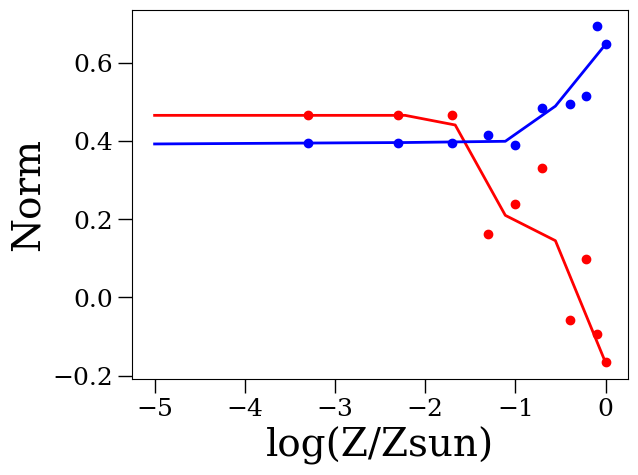

In [42]:
plot_logzs = np.linspace(-5, 0, 10)
plt.scatter(
    che_window_upper_boundary_fits[:, 0],
    che_window_upper_boundary_fits[:, 2],
    color='r'
)
plt.plot(
    plot_logzs,
    che_w_upper_bound_norm_ip(plot_logzs),
    'r'
)

plt.scatter(
    che_window_lower_boundary_fits[:, 0],
    che_window_lower_boundary_fits[:, 2],
    color='b'
)
plt.plot(
    plot_logzs,
    che_w_lower_bound_norm_ip(plot_logzs),
    'b'
)
plt.xlabel('log(Z/Zsun)')
plt.ylabel('Norm')

Text(0, 0.5, 'Slope')

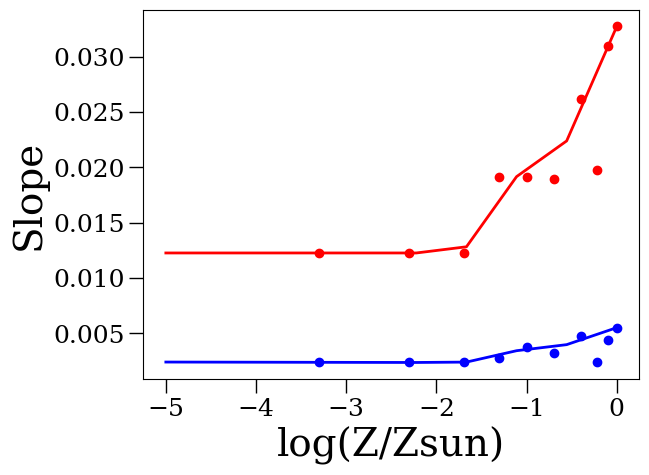

In [43]:
plot_logzs = np.linspace(-5, 0, 10)
plt.scatter(
    che_window_upper_boundary_fits[:, 0],
    che_window_upper_boundary_fits[:, 1],
    color='r'
)
plt.plot(
    plot_logzs,
    che_w_upper_bound_slope_ip(plot_logzs),
    'r'
)

plt.scatter(
    che_window_lower_boundary_fits[:, 0],
    che_window_lower_boundary_fits[:, 1],
    color='b'
)
plt.plot(
    plot_logzs,
    che_w_lower_bound_slope_ip(plot_logzs),
    'b'
)
plt.xlabel('log(Z/Zsun)')
plt.ylabel('Slope')

In [44]:
@np.vectorize
def is_in_che_window(m, p, logz):
    max_p = che_w_upper_bound_slope_ip(logz)*m + che_w_upper_bound_norm_ip(logz)
    min_p = che_w_lower_bound_slope_ip(logz)*m + che_w_lower_bound_norm_ip(logz)
    if p < max_p and p > min_p:
        return True
    else:
        return False

These fits are particularly useful for interpolators that do not already integrate the boundaries (i.e., yield nan outside of the CHE window), but this is not the case for our custom interpolator.

## Interpolating from the grids to a synthetic population

In [45]:
def interpolate(job, data, var):
    """Pickable function to interpolate from a pop array.
    
    Job is a (n_pop, n_var) array where n_var > 3. job[:,0] contains
    metallicities, job[:,1] contains m_zams and job[:,2] contains 
    p_spin_zams.
    """
    
    interpolator = PMZLinearInterpolator(data, var=var)
    vec_f = np.vectorize(interpolator.get_var)
    result = vec_f(job[:, 1], job[:, 2], job[:, 0])
    return result

def parallel_set_sample_var(sample, var, var_col_i, data, n_processes):
    run_job = partial(interpolate, data=data, var=var)
    
    with ProcessPoolExecutor(max_workers=n_processes) as executor:
        jobs = np.array_split(sample, n_processes)
        futures = {
            executor.submit(run_job, job): job_index for job_index, job in enumerate(jobs)
        }
        
        for future in tqdm(as_completed(futures), total=len(futures), desc=f'Collecting {var}'):
            job_index = futures[future]
            try:
                result = future.result()
            except Exception as e:
                print(f'Error in job {job_index}: {e}')
                continue
            sample[job_index*len(result):(job_index+1)*len(result), var_col_i] = result
    return sample

def draw_pop(
    data,
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_zdivzsun=0.1,
    max_zdivzsun=1.0,
    fixed_z=None,
    n_processes=36,
    vars=[
        'm_f',
        'x_f',
        't_d'
    ]
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))
    
    if fixed_z is not None:
        sample_zs = np.tile(fixed_z, int(res/100))
    else:
        sample_zs = np.linspace(np.log10(min_zdivzsun), np.log10(max_zdivzsun), res)
        sample_probs = np.ones(res)/res
        sample_zs = 10.**np.random.choice(sample_zs, p=sample_probs, size=int(res/100))

    # The first three columns of the sample array should aways be 
    # metallicity, m_zams and p_spin_zams, otherwise the 
    # parallel_set_sample_var function will not work.
    sample = np.array([
        sample_zs, 
        sample_masses, 
        sample_periods,
        *np.zeros((len(vars), int(res/100)))
        ]).T
    
    for i_var, var in enumerate(vars):
        i_var += 3
        sample = parallel_set_sample_var(
            sample=sample,
            var=var,
            var_col_i=i_var,
            data=data,
            n_processes=n_processes
        )
    
    return sample

In [49]:
res=int(1e8)
min_m=10
max_m=300
min_p=0.1
max_p=4
min_zdivzsun=0.0005
max_zdivzsun=1.0
fixed_z=None
n_processes=96
vars=[
    'm_f',
    'p_orb_f',
    'x_f',
    'min_x_f',
    'log_t_d'
]

sample = draw_pop(
    data=core_props_df,
    res=res,
    min_m=min_m,
    max_m=max_m,
    min_p=min_p,
    max_p=max_p,
    min_zdivzsun=min_zdivzsun,
    max_zdivzsun=max_zdivzsun,
    fixed_z=fixed_z,
    n_processes=n_processes,
    vars=vars
)

(0.0, 0.04)

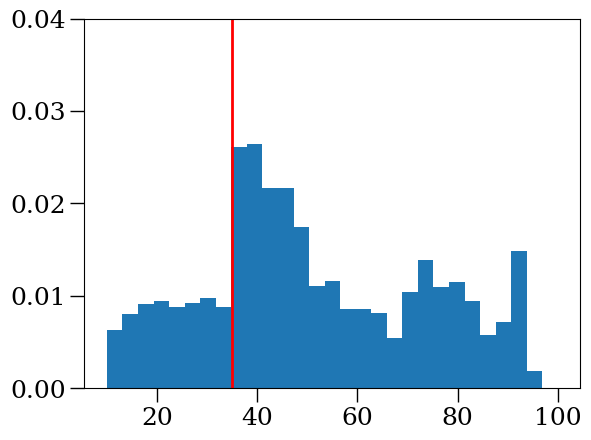

In [53]:
plt.hist(sample[:, 3], bins=np.linspace(10, 100, 30), density=True)
plt.vlines(35, 0, 1, color='red', label='35 Msun')
plt.ylim(0, 0.04)

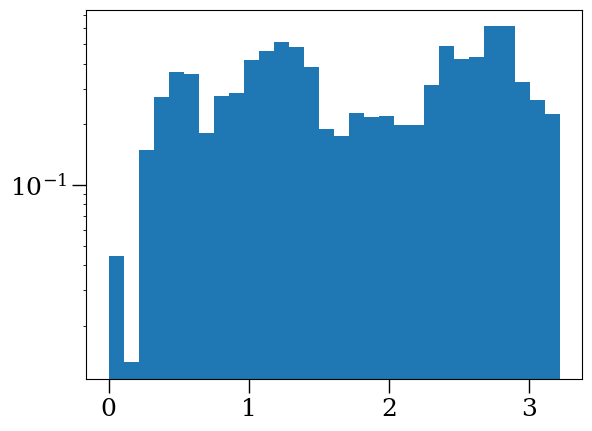

In [54]:
plt.hist(sample[:, 5], bins=30, density=True)
#plt.vlines(35, 0, 1, color='red', label='35 Msun')
plt.yscale('log')

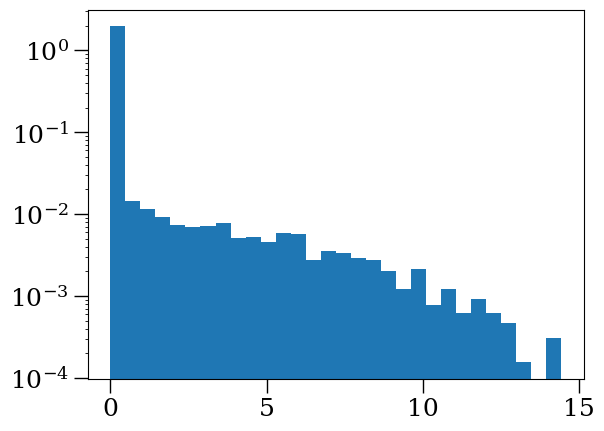

In [55]:
plt.hist(sample[:, 6], bins=30, density=True)
#plt.vlines(35, 0, 1, color='red', label='35 Msun')
plt.yscale('log')

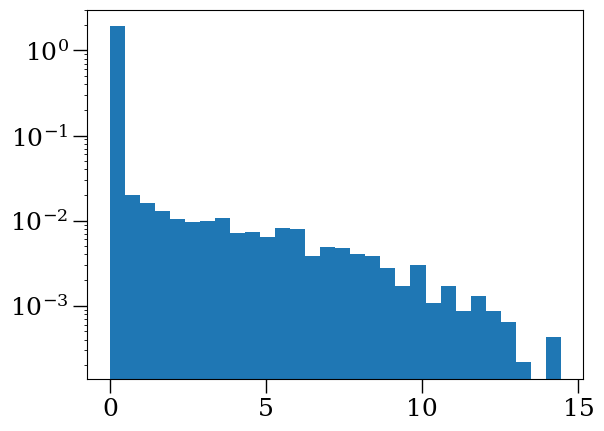

In [64]:
plt.hist(msample[:, -2], bins=30, density=True)
#plt.vlines(35, 0, 1, color='red', label='35 Msun')
plt.yscale('log')

(array([6.400e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 6.517e+03, 1.255e+03, 9.660e+02, 9.120e+02, 9.260e+02,
        6.110e+02, 5.060e+02, 5.150e+02, 4.100e+02, 3.360e+02, 1.760e+02,
        9.400e+01, 7.300e+01, 4.800e+01, 3.700e+01, 1.500e+01, 3.000e+00]),
 array([ 0.        ,  0.59887947,  1.19775895,  1.79663842,  2.39551789,
         2.99439737,  3.59327684,  4.19215631,  4.79103579,  5.38991526,
         5.98879473,  6.5876742 ,  7.18655368,  7.78543315,  8.38431262,
         8.9831921 ,  9.58207157, 10.18095104, 10.77983052, 11.37870999,
        11.97758946, 12.57646894, 13.17534841, 13.77422788, 14.37310736,
        14.97198683, 15.5708663 , 16.16974578, 16.76862525, 17.36750472,
        17.9663842 ]),
 <BarContainer object of 30 artists>)

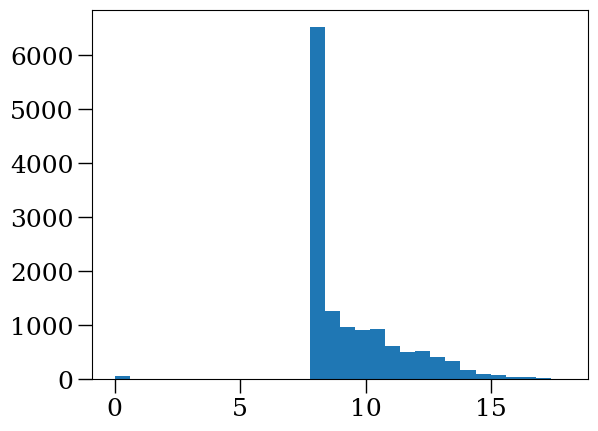

In [62]:
plt.hist(sample[:, -1], bins=30)

In [58]:
msample = sample[sample[:, -1] <= np.log10(t_h)]

np.save(DATA_ROOT/f'ip_pop_minz{min_zdivzsun}_maxz{max_zdivzsun}_res{res:.0e}_enhanced_w.npy', sample)
print(f'Saved sample with {len(sample)} stars to {DATA_ROOT/f"ip_pop_minz{min_zdivzsun}_maxz{max_zdivzsun}_res{res:.0e}_enhanced_w.npy"}')
np.save(DATA_ROOT/f'ip_pop_minz{min_zdivzsun}_maxz{max_zdivzsun}_res{res:.0e}_enhanced_w_mergers_only.npy', msample)
print(f'Saved sample with {len(msample)} stars to {DATA_ROOT/f"ip_pop_minz{min_zdivzsun}_maxz{max_zdivzsun}_res{res:.0e}_enhanced_w_mergers_only.npy"}')

Saved sample with 1000000 stars to /mnt/home/ldesa/repos/cher/data/ip_pop_minz0.0005_maxz1.0_res1e+08_enhanced_w.npy
Saved sample with 9661 stars to /mnt/home/ldesa/repos/cher/data/ip_pop_minz0.0005_maxz1.0_res1e+08_enhanced_w_mergers_only.npy


In [55]:
sample[:, 4]

array([1.39678237e+09,            nan,            nan, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

(array([105.,  34.,  52.,  49.,  52.,  46.,  40.,  21.,  16.,   5.]),
 array([ 7.79531205,  8.84252285,  9.88973364, 10.93694444, 11.98415524,
        13.03136604, 14.07857683, 15.12578763, 16.17299843, 17.22020923,
        18.26742002]),
 <BarContainer object of 10 artists>)

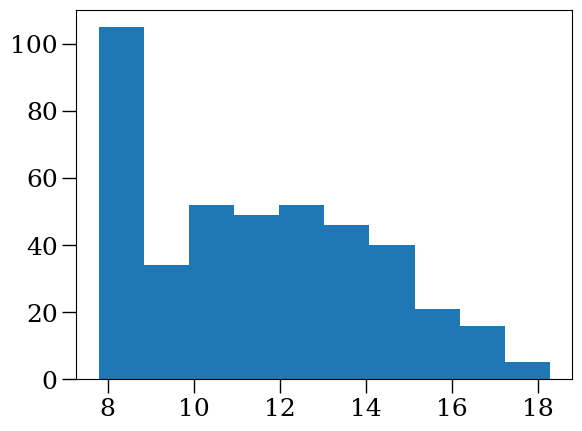

In [60]:
plt.hist(np.log10(core_props_df.t_d))

AttributeError: 'Figure' object has no attribute 'xscale'

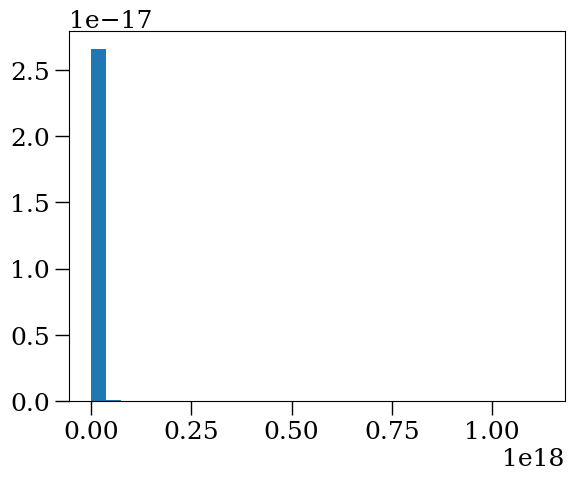

In [57]:
plt.hist(sample[:, 4], bins=30, density=True)
#plt.vlines(35, 0, 1, color='red', label='35 Msun')
#plt.ylim(0, 0.04)
fig.xscale('log')

(0.0, 0.1)

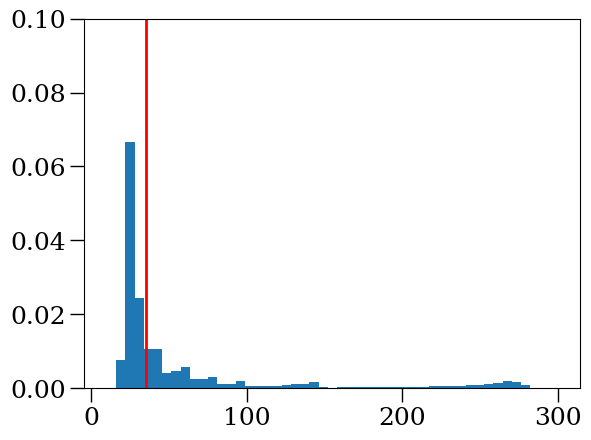

In [ ]:
plt.hist(rbf(sample[:,:3]), bins=np.linspace(10, 300, 50), density=True)
plt.vlines(35, 0, 1, color='red', label='35 Msun')
plt.ylim(0, 0.1)

(array([7143., 1025.,  500.,  170.,  309.,   61.,   86.,  128.,  184.,
         394.]),
 array([ 20.42139053,  46.46998453,  72.51857853,  98.56717253,
        124.61576653, 150.66436052, 176.71295452, 202.76154852,
        228.81014252, 254.85873652, 280.90733051]),
 <BarContainer object of 10 artists>)

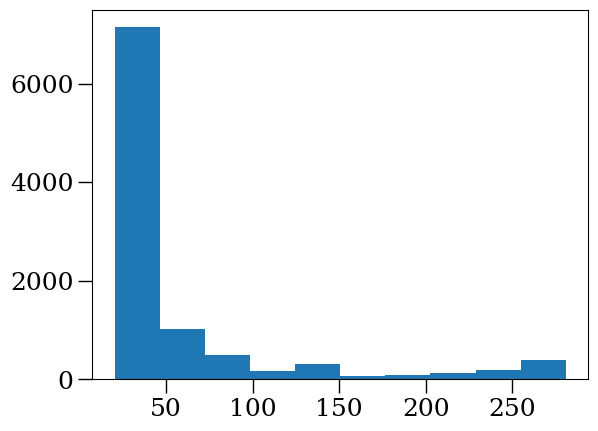

: 

In [ ]:
plt.hist(sample[:, 4])